<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Closeup of every potential circuit

In [14]:
def draw_image(image, figsize=(12, 16)):
  plt.figure(figsize=figsize)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

### Imports

In [70]:
!apt-get install -y poppler-utils
!pip install PyPDF2 pytesseract pdf2image opencv-python-headless
!pip install pytesseract
!apt install tesseract-ocr
!apt install libtesseract-dev


Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.86.1-0ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 htt

In [4]:
from PyPDF2 import PdfReader
import cv2
import pytesseract
from pdf2image import convert_from_path
import os
import matplotlib.pyplot as plt
import numpy as np

### Save as Images

In [15]:
def convert_pdf_to_images(pdf_path, start_page, end_page):
    images = []
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        for page_num in range(start_page - 1, end_page):
            if reader.is_encrypted:
                reader.decrypt('')
            page = reader.pages[page_num]
            images += convert_from_path(pdf_path, first_page=page_num + 1, last_page=page_num + 1, fmt='jpeg')
    return images

book_pdf_path = '/content/drive/MyDrive/Photo Circuit/Fundamentals_of_Electric_Circuits_6th_Sadiku.pdf'
# pages_all = convert_pdf_to_images(book_pdf_path, 390, 575)
pages_pil = convert_pdf_to_images(book_pdf_path, 462, 476)
images = [np.array(pil_image) for pil_image in pages_pil]  # Convert PIL images to NumPy arrays
pages = [cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if image.ndim == 2 else image for image in images]  # Convert grayscale images to BGR


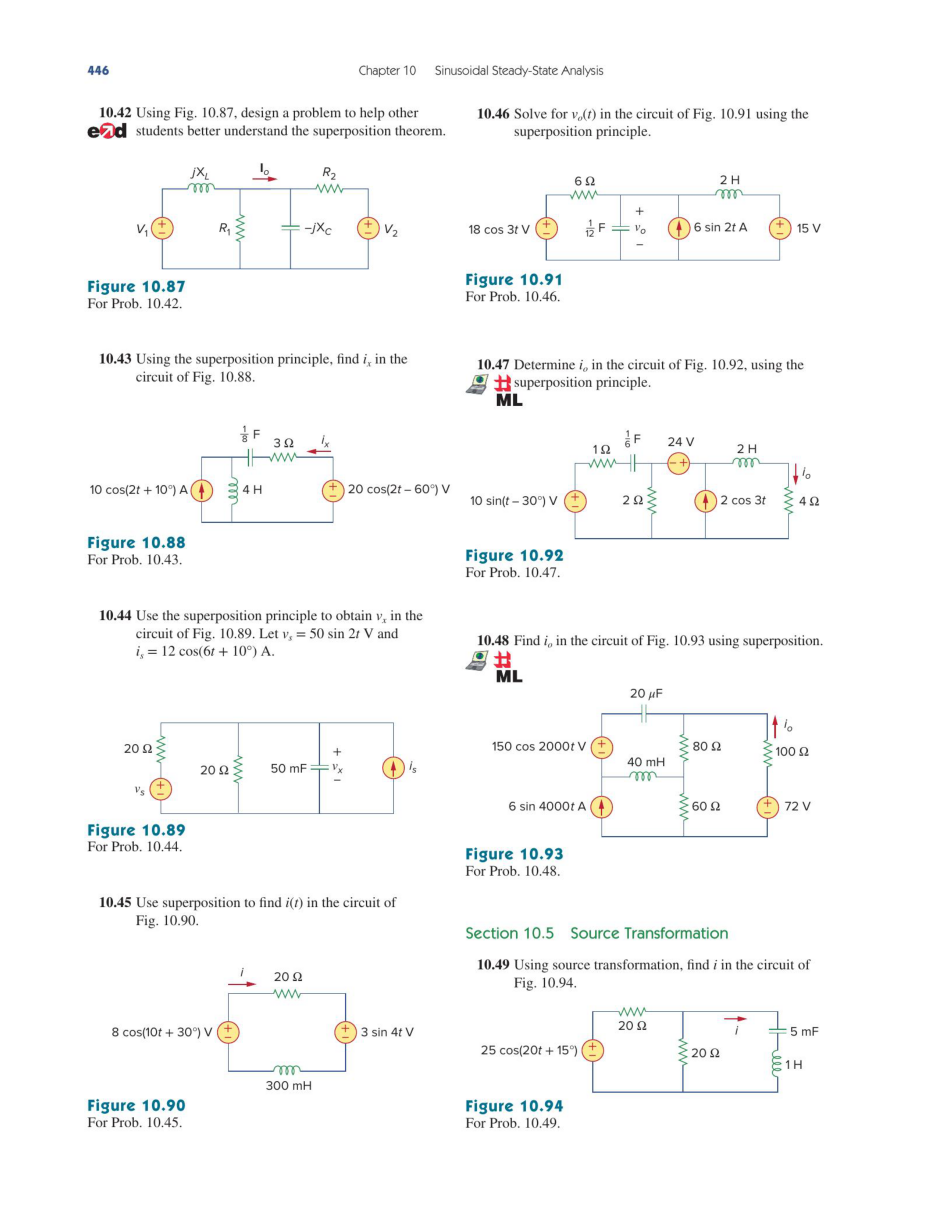

In [54]:
# Assuming you have already run the main() function
TEST_PAGE = 7
first_page_image = pages_pil[TEST_PAGE]
draw_image(first_page_image)

### Get Contours

In [55]:
def find_contours(image, kernel_size=3, threshold=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

    # Perform Sobel edge detection
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_magnitude = np.uint8(sobel_magnitude / np.max(sobel_magnitude) * 255)

    # Threshold the Sobel magnitude to create a binary image
    _, binary_image = cv2.threshold(sobel_magnitude, threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours



contours = [find_contours(page) for page in pages]

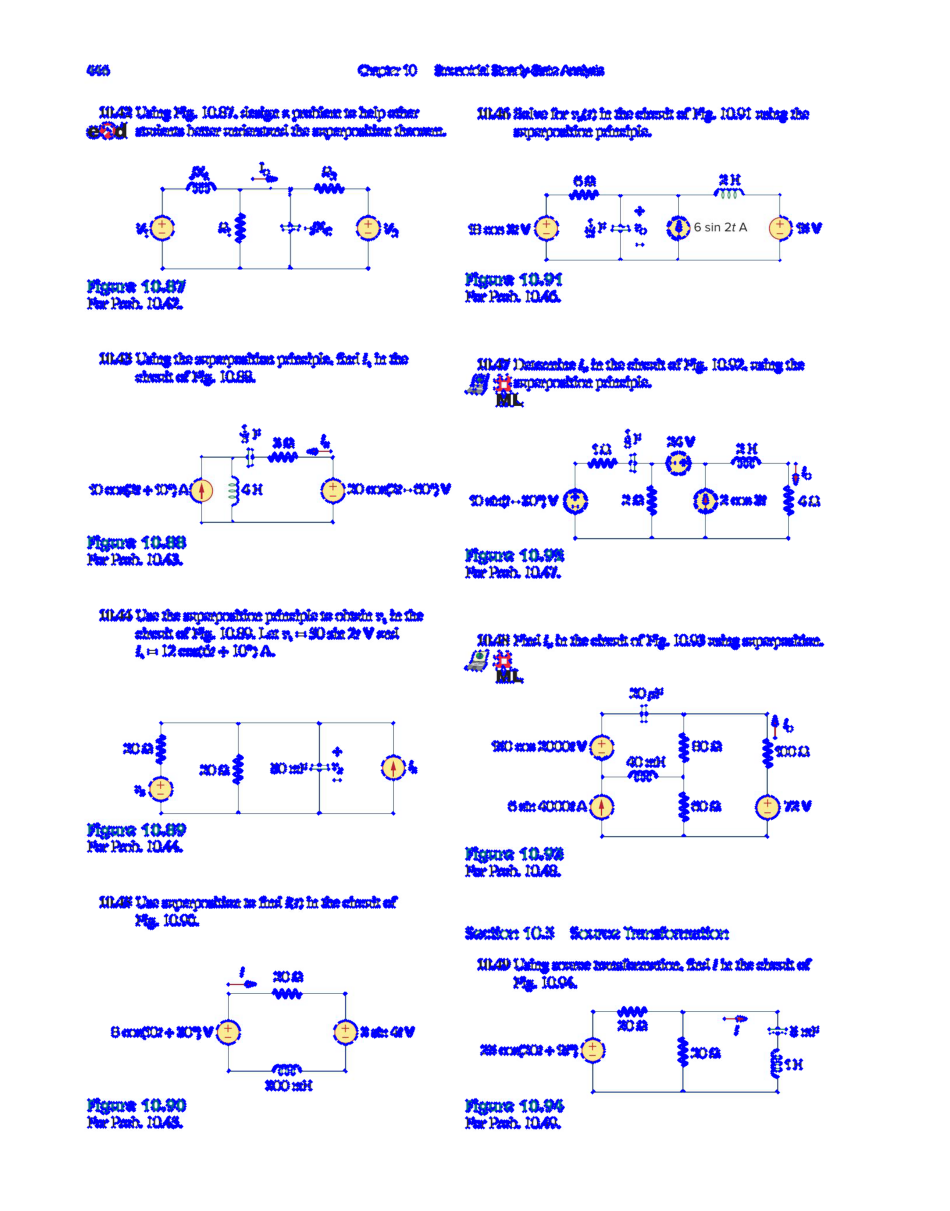

In [56]:
image_with_dots = images[TEST_PAGE].copy()
dot_radius=2
color=(0, 0, 255)
for contour in contours[TEST_PAGE]:
    for point in contour:
        x, y = point[0]
        cv2.circle(image_with_dots, (x, y), dot_radius, color, -1)
draw_image(image_with_dots)

## Get Bounding Boxes

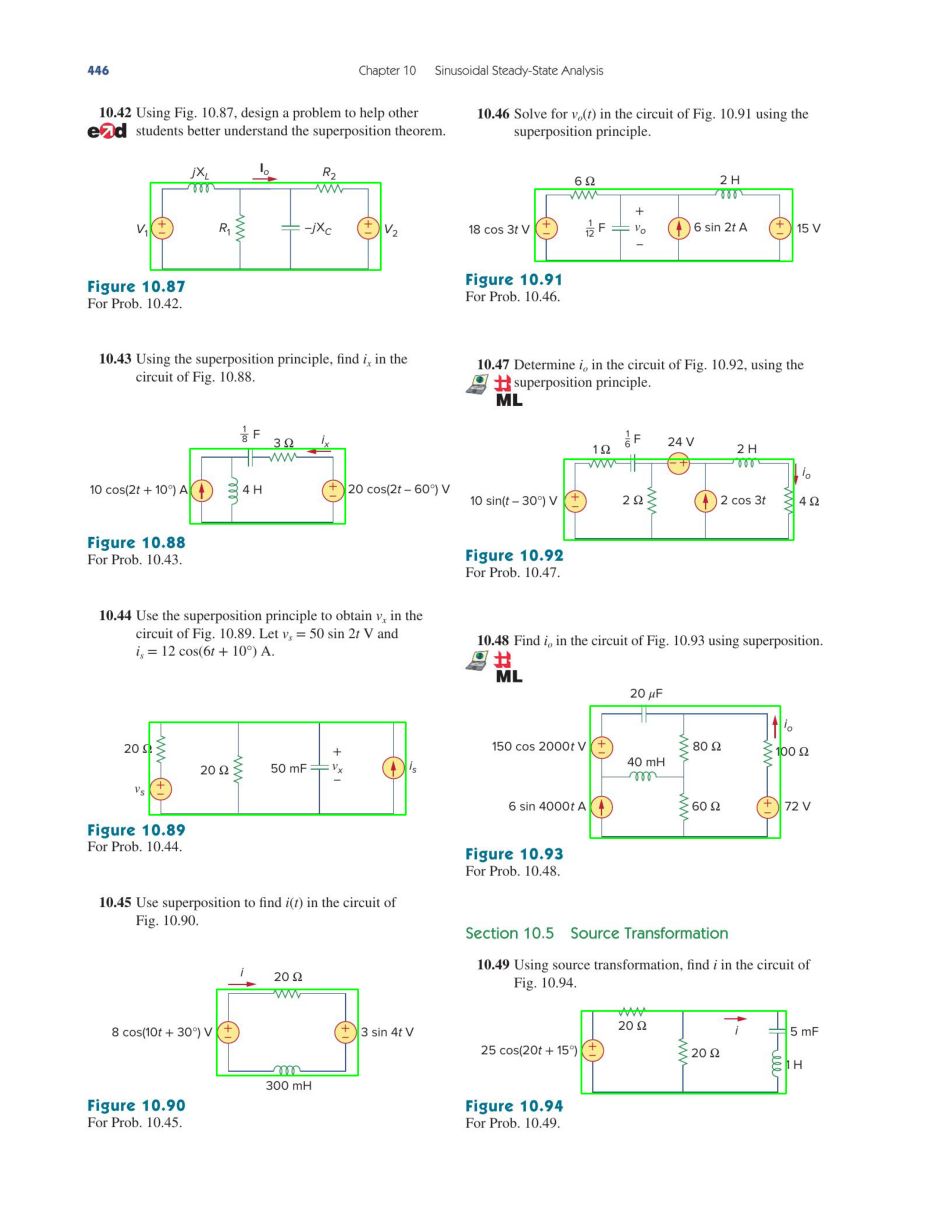

In [57]:
def draw_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):
    image_with_boxes = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
    return image_with_boxes

def get_bounding_boxes(contours, min_length):
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        if w < min_length or h < min_length:
          continue

        yield (x, y, w, h)


min_length = images[0].shape[1] * 0.05
bounding_boxes = [list(get_bounding_boxes(contour, min_length)) for contour in contours]
images_with_boxes = [draw_bounding_boxes(images[i], bounding_boxes[i]) for i in range(len(images))]

draw_image(images_with_boxes[TEST_PAGE])
        

### Remove Overlapping Bounding Boxes

In [58]:
import copy

def intervals_overlap(intr1, intr2, reversed_call=False): 
  # intr1: -------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr2[0] < intr1[1]:
    return True
  # intr1:  -----------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr1[1] > intr2[1]:
    return True

  if not reversed_call:
    return intervals_overlap(intr2, intr1, True)
  else:
    return False

def get_intervals_for_rect(rect):
  x, y, w, h = rect
  xintr = (x, x + w)
  yintr = (y, y + h)
  return xintr, yintr

def merge_rects(rect1, rect2):
  x1, y1, w1, h1 = rect1
  x2, y2, w2, h2 = rect2

  right1 = x1 + w1
  top1 = y1 + h1
  right2 = x2 + w2
  top2 = y2 + h2

  xn = min(x1, x2)
  yn = min(y1, y2)
  
  rightn = max(right1, right2)
  topn = max(top1, top2)

  wn = rightn - xn
  hn = topn - yn
  return xn, yn, wn, hn

def combine_overlapping_rects(rectangles_input):
    found_overlap = True
    overlapping_indexes = (-1,-1)
    rectangles = copy.deepcopy(rectangles_input)
    while found_overlap:
      found_overlap = False
      for i, rect1 in enumerate(rectangles):
        xintr1, yintr1 = get_intervals_for_rect(rect1)
        for j, rect2 in enumerate(rectangles):
          xintr2, yintr2 = get_intervals_for_rect(rect2)
          
          if intervals_overlap(xintr1, xintr2) and intervals_overlap(yintr1, yintr2):
            found_overlap = True
            overlapping_indexes = (i, j)
            break
        if found_overlap:
          break
      
      if found_overlap:
        idx1, idx2 = overlapping_indexes
        rect1 = rectangles[idx1]
        rect2 = rectangles[idx2]
        rectn = merge_rects(rect1, rect2)
        rectangles = [x for i, x in enumerate(rectangles) if i not in overlapping_indexes]
        rectangles.append(rectn)
    return rectangles
    
bounding_boxes_page = bounding_boxes[TEST_PAGE]
combine_overlapping_rects(bounding_boxes_page)


[(982, 1721, 352, 142),
 (355, 1684, 243, 148),
 (239, 1225, 441, 159),
 (997, 1197, 327, 227),
 (952, 773, 395, 139),
 (309, 755, 267, 129),
 (902, 309, 443, 124),
 (241, 298, 396, 150)]

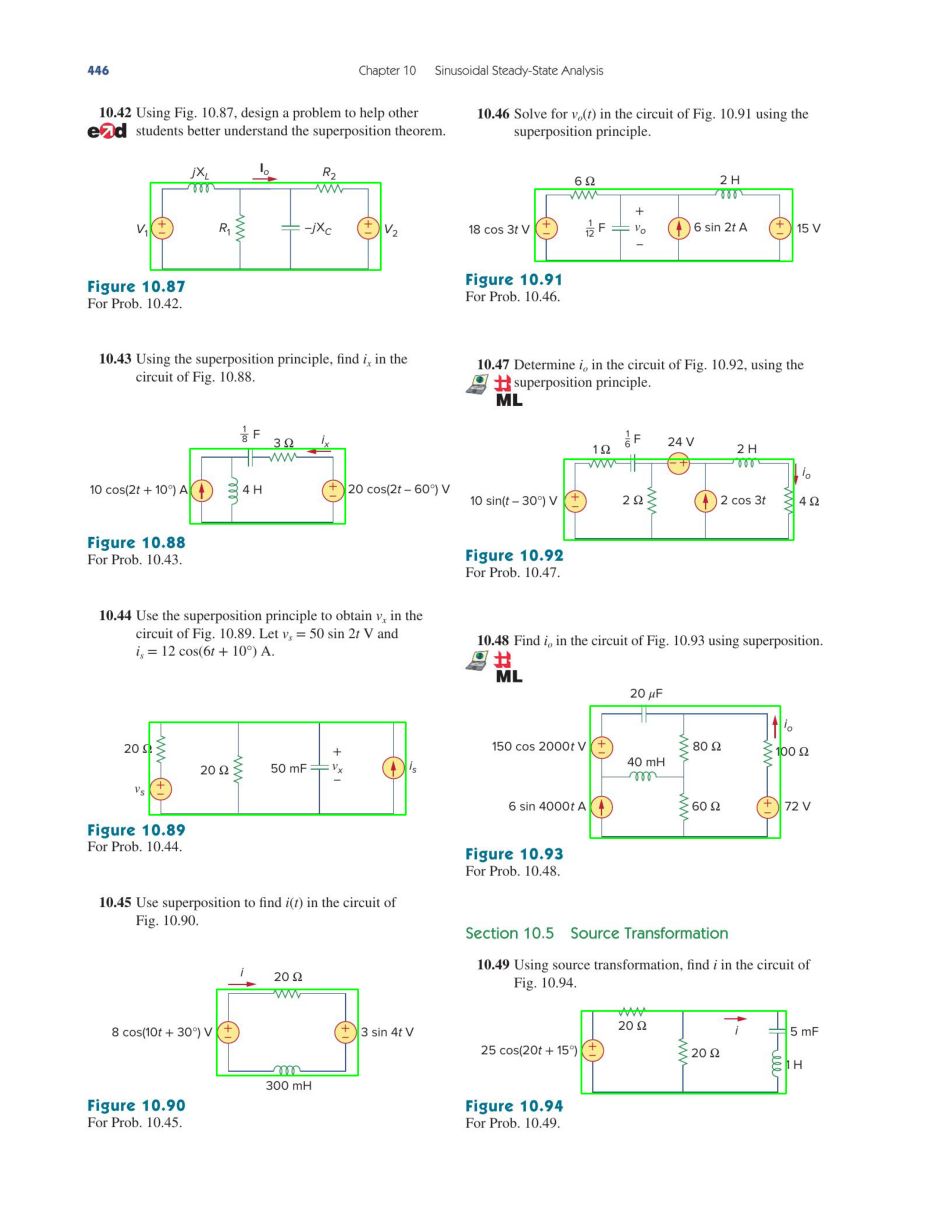

In [59]:
bounding_boxes_no_ol = [combine_overlapping_rects(list(bounding_boxes_i)) for bounding_boxes_i in bounding_boxes]
images_with_boxes = [draw_bounding_boxes(images[i], bounding_boxes_no_ol[i]) for i in range(len(images))]
draw_image(images_with_boxes[TEST_PAGE])

## Expand bounding boxes to capture unit labels

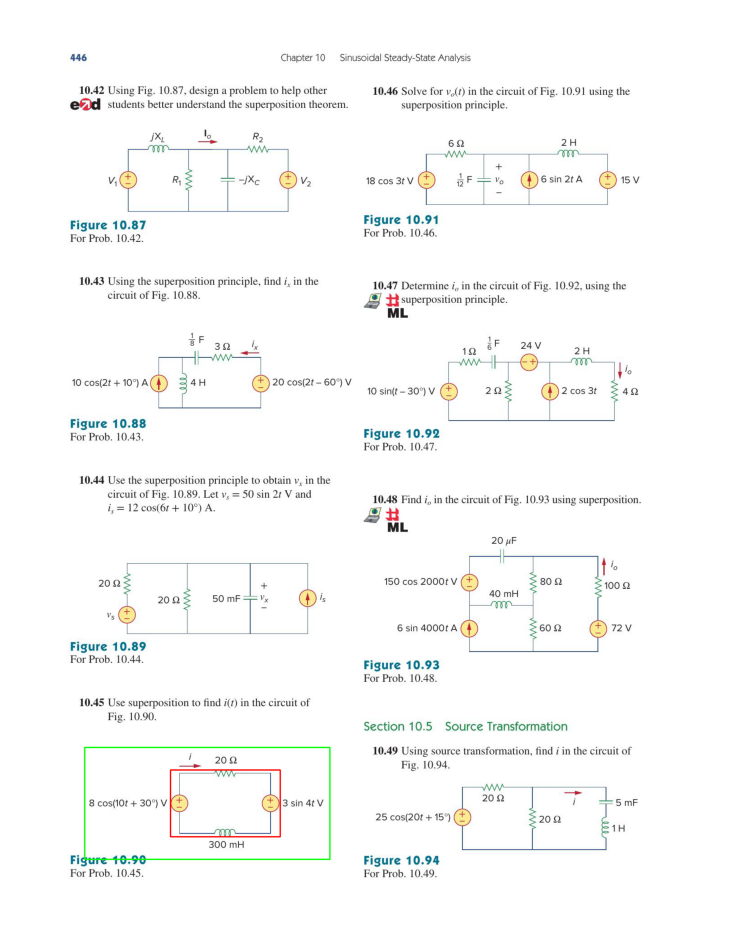

In [62]:
def get_potential_points_around_bounding_box(bounding_box, contours, max_size):
  x, y, w, h = bounding_box
  x -= max_size
  y -= max_size
  w += 2 * max_size
  h += 2 * max_size

  res = []
  for contour in contours:
    for point in contour:
      px, py = point[0]
      if (x <= px < x + w) and (y <= py < y + h):
        res += [(px, py)]
  return res

def find_points_not_in_box(bounding_box, points):
  x, y, w, h = bounding_box
  new_points = [
      (px, py) 
      for px, py in points
      if not ((x <= px < x + w) and (y <= py < y + h))
  ]
  return new_points

def expand_bounding_box(bounding_box, contours, step_size, max_steps, fixed_padding):
  # global images
  # Find all points that it is possible for this process to reach
  max_expansion_for_box = step_size * max_steps
  potential_points = get_potential_points_around_bounding_box(
      bounding_box, contours, max_expansion_for_box
  )

  #  Uncomment to show image with potential points and bounding box labeled
  # image_with_dots = images[1].copy()
  # dot_radius=2
  # color=(0, 0, 255)
  # for point in potential_points:
  #   x, y = point
  #   cv2.circle(image_with_dots, (x, y), dot_radius, color, -1)
  # xb, yb, wb, hb = bounding_box
  # cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (0, 255, 0), 2)
  # draw_image(image_with_dots)

  # Expand each surface as number of points captured increases
  right_transform = lambda x, y, w, h: (x, y, w + step_size, h)
  up_transform    = lambda x, y, w, h: (x, y, w, h + step_size)
  left_transform  = lambda x, y, w, h: (x - step_size, y, w + step_size, h)
  down_transform  = lambda x, y, w, h: (x, y - step_size, w, h + step_size)
  transforms = [
      right_transform,
      up_transform,
      left_transform,
      down_transform
  ]
  x, y, w, h = bounding_box
  points_not_in_box = find_points_not_in_box((x, y, w, h), potential_points)
  for transform in transforms:
    for _ in range(max_steps):
      xn, yn, wn, hn = transform(x, y, w, h)
      new_points_not_in_box = find_points_not_in_box((xn, yn, wn, hn), points_not_in_box)
      if len(new_points_not_in_box) == len(points_not_in_box):
        break
      else:
        points_not_in_box = new_points_not_in_box
        x, y, w, h = xn, yn, wn, hn
  
  x -= fixed_padding 
  y -= fixed_padding
  w += 2 * fixed_padding
  h += 2 * fixed_padding

  return x, y, w, h

step_size = 20
max_steps = 20
fixed_padding = 10
max_expansion_for_box = step_size * max_steps

bounding_box = expand_bounding_box(bounding_boxes_no_ol[TEST_PAGE][1], contours[TEST_PAGE], step_size, max_steps, fixed_padding)

image_with_dots = images[TEST_PAGE].copy()
dot_radius=2
color=(0, 0, 255)
xb, yb, wb, hb = bounding_boxes_no_ol[TEST_PAGE][1]
cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (255, 0, 0), 2)
xb, yb, wb, hb = bounding_box
cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (0, 255, 0), 2)
draw_image(image_with_dots, figsize=(16, 12))

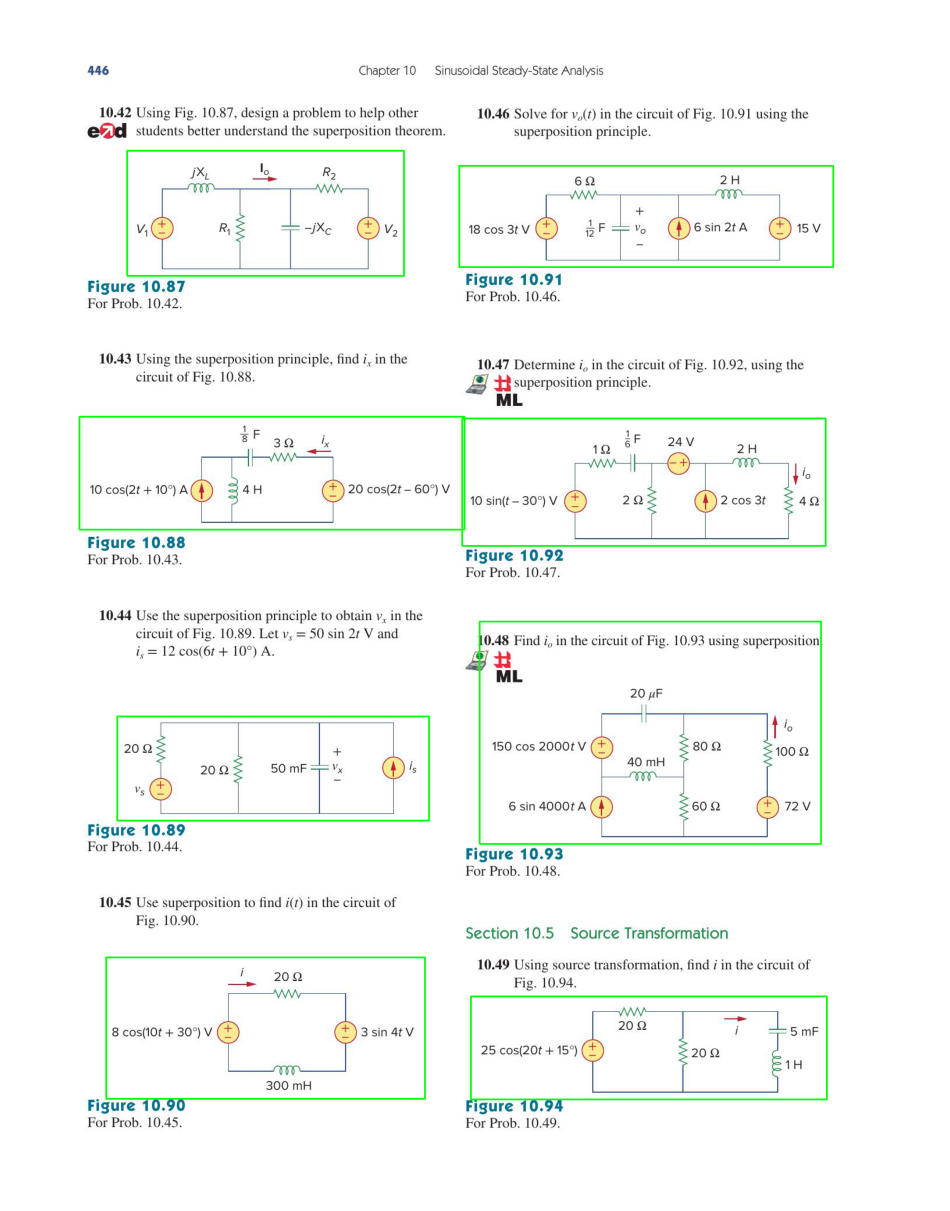

In [68]:
def expand_bounding_boxes(bounding_boxes, contours, step_size, max_steps, fixed_padding = 10):
  return [
      expand_bounding_box(bounding_box, contours, step_size, max_steps, fixed_padding)
      for bounding_box in bounding_boxes
  ]

max_steps = 20
step_size = 15
fixed_padding = 10
bounding_boxes_expanded = [
    expand_bounding_boxes(bounding_boxes_i, contours_i, step_size, max_steps, fixed_padding) 
    for bounding_boxes_i, contours_i in zip(bounding_boxes_no_ol, contours)
]
image_with_box = draw_bounding_boxes(images[TEST_PAGE], bounding_boxes_expanded[TEST_PAGE])
draw_image(image_with_box)

## Extract circuit closeups from images and bounding boxes

In [75]:
import cv2
import os
import shutil

output_directory = 'circuits_raw'

# Remove the directory and its contents if it exists
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

# Create a directory to store the close-ups
os.makedirs(output_directory, exist_ok=True)

circuit_images = []
for i, (bounding_boxes, image) in enumerate(zip(bounding_boxes_expanded, images)):
  for j, (x, y, w, h) in enumerate(bounding_boxes):
      circuit_closeup = image[y:y + h, x:x + w]
      circuit_closeup = cv2.cvtColor(circuit_closeup, cv2.COLOR_BGR2GRAY)
      close_up_filename = f'{output_directory}/circuit_page_{i}_circuit_{j}.png'
      cv2.imwrite(close_up_filename, circuit_closeup)
      circuit_images.append(circuit_closeup)

# Manually try to filter for only circuits

## Find all Text in images

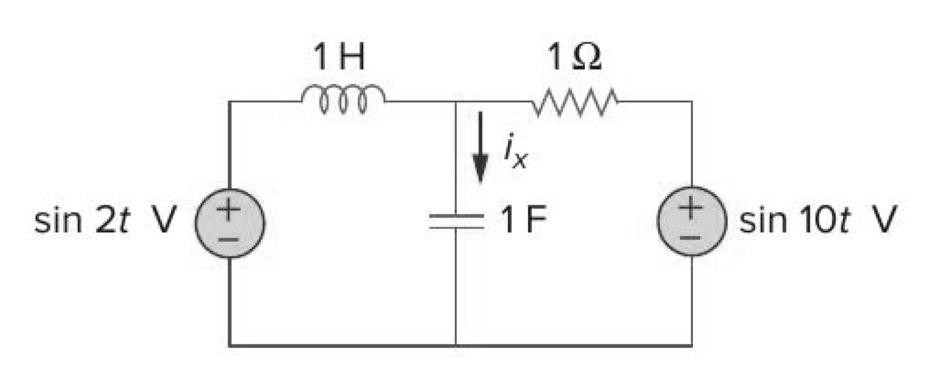

In [76]:
import cv2
import pytesseract
from pytesseract import Output

test_image = circuit_images[3]
draw_image(test_image)

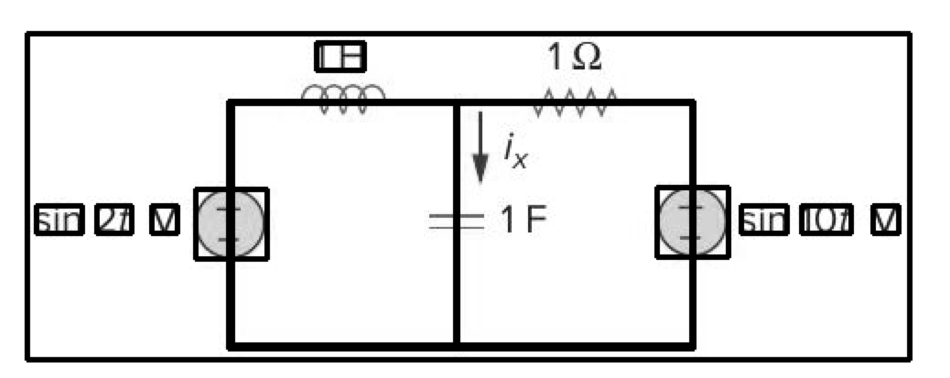

In [78]:
data = pytesseract.image_to_data(test_image, output_type=Output.DICT)

# Loop over the OCR data and draw bounding boxes around the text
for i, _ in enumerate(data['text']):
    if int(data['conf'][i]) > 50:  # Set a minimum confidence level for the detected text
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the image with the text bounding boxes
draw_image(test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()